We built a difficulty score model that has uses regression to predict RMSD, and classification to predict hardness probability (p_hard).

p_hard is a number between 0 and 1 that means “How likely does the model think this antibody will be hard, meaning its RMSD will be ≥ 3.0 Å?” So p_hard = 0.80 means model thinks 80% chance the RMSD is ≥ 3.0 Å

#### Hardness truth vs predicted probability

* If y_classification_true_01=1 but p_hard is low it means false-negative risk.
* If y_classification_true_01=0 but p_hard is high it means false-positive risk.

In [1]:
import json
from pathlib import Path
from typing import Any, Dict, Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    brier_score_loss,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.calibration import calibration_curve
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV
import train_difficulty_score as tds

In [2]:
PROJECT_ROOT = Path(".").resolve()
CSV_PATH = PROJECT_ROOT / "h3_features.csv"
RUN_DIRS = {
    "basicrun": PROJECT_ROOT / "outputs_basicrun",
    "physchem": PROJECT_ROOT / "outputs_physchem",
    "engineered": PROJECT_ROOT / "outputs_engineered",
    "esm_alpha10": PROJECT_ROOT / "outputs_esm_alpha10",
}
FINAL_DIR = RUN_DIRS["esm_alpha10"]
ESM_CACHE = PROJECT_ROOT / "outputs" / "esm_cache.csv"
pd.set_option("display.max_columns", 200)

In [3]:
final_pred_path = FINAL_DIR / "predictions_test.csv"
final_df = pd.read_csv(final_pred_path)
final_df.head(20)

,id,y_regression_true,y_classification_true_01,pred_rmsd,pred_rmsd_lower_prediction_interval_bounds,pred_rmsd_upper_prediction_interval_bounds,p_hard
0,8TFN_HL,2.028279,0,3.154859,1.302078,5.007640,0.385426
1,8FAS_AB,3.017691,1,2.246742,0.393960,4.099523,0.233560
2,9BYF_HL,2.764492,0,2.835668,0.982887,4.688449,0.575609
3,8V52_DC,1.125007,0,2.329295,0.476514,4.182076,0.266067
4,7VMZ_HL,2.549352,0,3.459953,1.607172,5.312735,0.767286
5,7WKX_AC,1.418618,0,2.017741,0.164960,3.870522,0.382363
6,9JPV_AB,9.159225,1,3.766414,1.913633,5.619196,0.437875
7,9MIC_HL,2.396624,0,3.019597,1.166816,4.872378,0.567602
8,9IY0_HL,2.132102,0,1.870565,0.017784,3.723347,0.231651
9,8YXI_CB,7.661405,1,3.581291,1.728509,5.434071,0.673220


#### cases where truth is hard (1) and p_hard is relatively high, or regression is near the hard threshold (probability is aligned with being above threshold):

* 8D54_AB (true 3.17 hard=1, pred 3.31, PI [1.46, 5.17], p_hard 0.76)
* 7TQG_HL (true 3.35, pred 3.72, p_hard 0.74)
* 8VEG_BA (true 3.22, pred 3.67, p_hard 0.74)
* 9GOY_HL (true 4.81, pred 3.45, p_hard 0.64)

#### false negatives (dangerous misses where Truth hard=1 but p_hard low):

* 8FAS_AB (true 3.02 hard=1, pred 2.25, p_hard 0.23)
* 9JPV_AB (true 9.16 hard=1, pred 3.77, p_hard 0.44)
* 8YXI_CB (true 7.66 hard=1, pred 3.58, p_hard 0.67)

These imply for very hard cases, regression saturates around ~3-4 and can miss badly. so the model is conservative in RMSD scale and relies more on p_hard for risk signaling.

#### truth not hard=0 but p_hard high:

* 7VMZ_HL (true 2.55 not-hard, pred 3.46, p_hard 0.77)
* 9BYF_HL (true 2.76 not-hard, pred 2.84, p_hard 0.58)
* 9MIC_HL (true 2.40 not-hard, pred 3.02, p_hard 0.57)

These are often samples where true RMSD is close-ish to 3.0

#### regression overestimates on easy cases
* 7WBZ_HL (true 1.13, pred 1.43, PI [-0.43, 3.28], p_hard 0.17)
Regression slightly high but still fine and PI includes negative lower bound

the classifier head (p_hard) is doing the “risk” job better than regression in extreme hard cases

rows like 9JPV_AB and 8YXI_CB show regression underestimates severely, but p_hard at least rises (0.44–0.67).

we also seen true RMSD 7–9 predicted ~3–4, which could indicate limited feature signal for extreme cases, or model trained with loss that shrinks extremes toward the mean (typical for RMSE/MAE), or distribution shift (extreme cases not represented enough in training)

#### does the prediction interval (PI) contain the true RMSD? (coverage indicator per row.)
so for each row we're checking if PI lower bound ≤ true RMSD ≤ PI higher bound

In [4]:
y = final_df["y_regression_true"].to_numpy(float)
lo = final_df["pred_rmsd_lower_prediction_interval_bounds"].to_numpy(float)
hi = final_df["pred_rmsd_upper_prediction_interval_bounds"].to_numpy(float)

final_df["pi_covers_true"] = (y >= lo) & (y <= hi)
print("Empirical PI coverage:", final_df["pi_covers_true"].mean())

Empirical PI coverage: 0.9178082191780822


on the held-out test set, the conformal prediction intervals achieved 91.78% empirical coverage (67/73), exceeding the nominal 90% target for α=0.10.

In [5]:
# Cell — Add per-row PI coverage indicator + inspect misses

import numpy as np
import pandas as pd

# adjust these if your column names differ
col_y = "y_regression_true"
col_lo = "pred_rmsd_lower_prediction_interval_bounds"
col_hi = "pred_rmsd_upper_prediction_interval_bounds"

final_df["pi_covers_true"] = (
    (final_df[col_y] >= final_df[col_lo]) &
    (final_df[col_y] <= final_df[col_hi])
)

coverage = final_df["pi_covers_true"].mean()
n_miss = (~final_df["pi_covers_true"]).sum()

print(f"Empirical PI coverage: {coverage:.3f} ({int(final_df.shape[0] - n_miss)}/{final_df.shape[0]} covered)")
print(f"Misses (outside PI):  {n_miss}")

final_df.loc[~final_df["pi_covers_true"], ["id", col_y, col_lo, col_hi, "pred_rmsd"]].sort_values(col_y, ascending=False).head(20)

Empirical PI coverage: 0.918 (67/73 covered)
Misses (outside PI):  6


,id,y_regression_true,pred_rmsd_lower_prediction_interval_bounds,pred_rmsd_upper_prediction_interval_bounds,pred_rmsd
6,9JPV_AB,9.159225,1.913633,5.619196,3.766414
9,8YXI_CB,7.661405,1.728509,5.434071,3.581291
59,7X8T_CB,7.539803,2.748877,6.454439,4.601658
36,8UHH_HL,5.136432,0.612012,4.317575,2.464794
54,8YKT_HL,3.033141,3.437738,7.143300,5.290519
23,8DF5_MN,1.400955,1.406635,5.112197,3.259416


In [6]:
def load_json(p: Path) -> Dict[str, Any]:
    with p.open("r") as f:
        return json.load(f)

def safe_get(d: Dict[str, Any], path: str, default=np.nan):
    cur: Any = d
    for k in path.split("."):
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur

def rebuild_ds_for_run(run_dir: Path) -> Tuple[tds.Dataset, np.ndarray, np.ndarray, Dict[str, Any]]:
    res = load_json(run_dir / "results_summary.json")

    feature_set = safe_get(res, "dataset.feature_set")
    target_rmsd_col = safe_get(res, "dataset.target_rmsd_col", "rmsd_h3_ctx")
    agree_tol = float(safe_get(res, "dataset.agree_tol", tds.AGREE_TOL_DEFAULT))
    hard_ge = float(safe_get(res, "dataset.hard_ge", tds.HARD_GE_DEFAULT))
    test_size = float(safe_get(res, "dataset.split.test_size", tds.TEST_SIZE_DEFAULT))

    use_esm = (feature_set == "engineered_esm")

    ds = tds.build_dataset(
        csv_path=CSV_PATH,
        target_rmsd_col=target_rmsd_col,
        agree_tol=agree_tol,
        hard_ge=hard_ge,
        feature_set=feature_set,
        use_esm=use_esm,
        esm_model="facebook/esm2_t6_8M_UR50D",
        esm_cache_path=ESM_CACHE,
    )

    train_idx, test_idx = tds.split_train_test(ds.ids, ds.y_classification, test_size=test_size)
    return ds, train_idx, test_idx, res

In [7]:
def pick_col(candidates):
    for c in candidates:
        if c in final_df.columns:
            return c
    raise KeyError(f"None of these columns exist: {candidates}")

col_y_reg = pick_col(["y_regression_true", "y_reg_true"])
col_y_hat = pick_col(["pred_rmsd", "pred_rmsd_cv_avg", "pred_rmsd_test"])
col_pi_lo = pick_col(["pred_rmsd_lower_prediction_interval_bounds", "pred_rmsd_pi_lo"])
col_pi_hi = pick_col(["pred_rmsd_upper_prediction_interval_bounds", "pred_rmsd_pi_hi"])
col_y_hard = pick_col(["y_classification_true_01", "y_hard_true01", "y_hard_true01"])
col_p_hard = pick_col(["p_hard", "p_hard_cv_avg"])

(col_y_reg, col_y_hat, col_pi_lo, col_pi_hi, col_y_hard, col_p_hard)

('y_regression_true',
 'pred_rmsd',
 'pred_rmsd_lower_prediction_interval_bounds',
 'pred_rmsd_upper_prediction_interval_bounds',
 'y_classification_true_01',
 'p_hard')

In [8]:
THESIS_DIR = FINAL_DIR / "thesis_plots"
THESIS_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name: str):
    png = THESIS_DIR / f"{name}.png"
    pdf = THESIS_DIR / f"{name}.pdf"
    plt.savefig(png, dpi=300, bbox_inches="tight")
    plt.savefig(pdf, bbox_inches="tight")

plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
})

Threshold used on test: 0.4892127911249797
Confusion matrix counts: {'tp': 22, 'fp': 7, 'tn': 34, 'fn': 10}
Precision: 0.759 | Recall: 0.688 | F1: 0.721


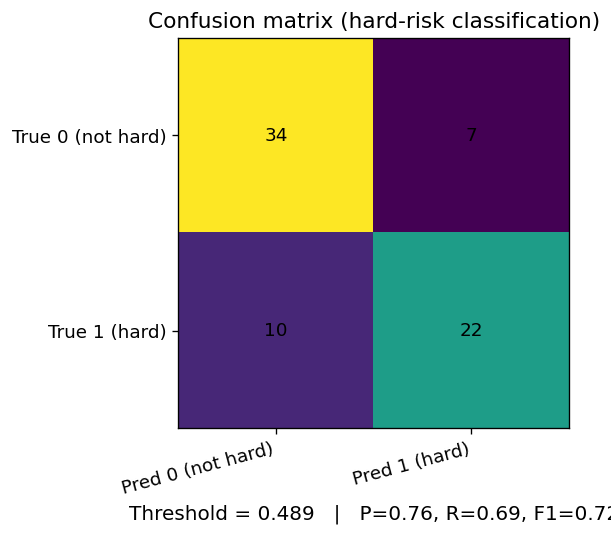

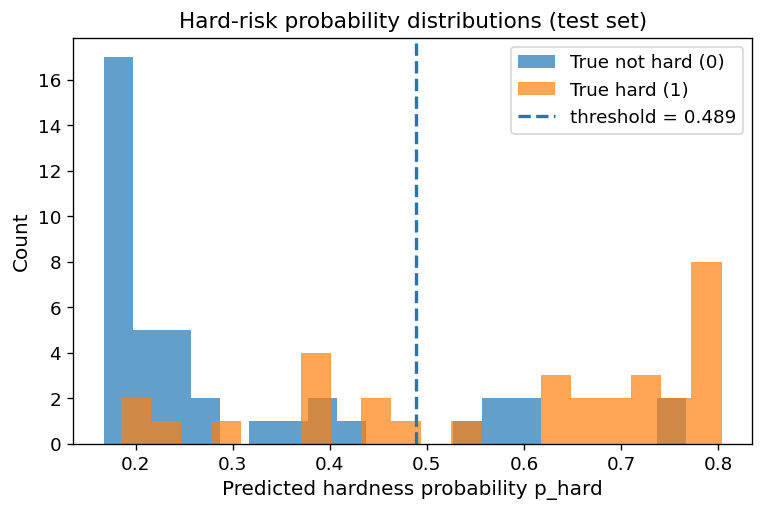

In [14]:
y_col = "y_classification_true_01"
p_col = "p_hard"

y_true = final_df[y_col].to_numpy(dtype=int)
p = final_df[p_col].to_numpy(dtype=float)

thr = 0.4892127911249797

y_pred = (p >= thr).astype(int)

tp = int(np.sum((y_pred == 1) & (y_true == 1)))
fp = int(np.sum((y_pred == 1) & (y_true == 0)))
tn = int(np.sum((y_pred == 0) & (y_true == 0)))
fn = int(np.sum((y_pred == 0) & (y_true == 1)))

precision = 0.0 if (tp + fp) == 0 else tp / (tp + fp)
recall = 0.0 if (tp + fn) == 0 else tp / (tp + fn)
f1 = 0.0 if (precision + recall) == 0 else 2 * precision * recall / (precision + recall)

print("Threshold used on test:", thr)
print("Confusion matrix counts:", {"tp": tp, "fp": fp, "tn": tn, "fn": fn})
print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

cm = np.array([[tn, fp],
               [fn, tp]])

plt.figure(figsize=(5.5, 4.6))
plt.imshow(cm)
plt.title("Confusion matrix (hard-risk classification)")
plt.xticks([0, 1], ["Pred 0 (not hard)", "Pred 1 (hard)"], rotation=15, ha="right")
plt.yticks([0, 1], ["True 0 (not hard)", "True 1 (hard)"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.xlabel(f"Threshold = {thr:.3f}   |   P={precision:.2f}, R={recall:.2f}, F1={f1:.2f}")
plt.tight_layout()
plt.show()
p0 = p[y_true == 0]
p1 = p[y_true == 1]

plt.figure(figsize=(6.5, 4.4))
plt.hist(p0, bins=20, alpha=0.7, label="True not hard (0)")
plt.hist(p1, bins=20, alpha=0.7, label="True hard (1)")
plt.axvline(thr, linestyle="--", linewidth=2, label=f"threshold = {thr:.3f}")

plt.xlabel("Predicted hardness probability p_hard")
plt.ylabel("Count")
plt.title("Hard-risk probability distributions (test set)")
plt.legend()
plt.tight_layout()
plt.show()

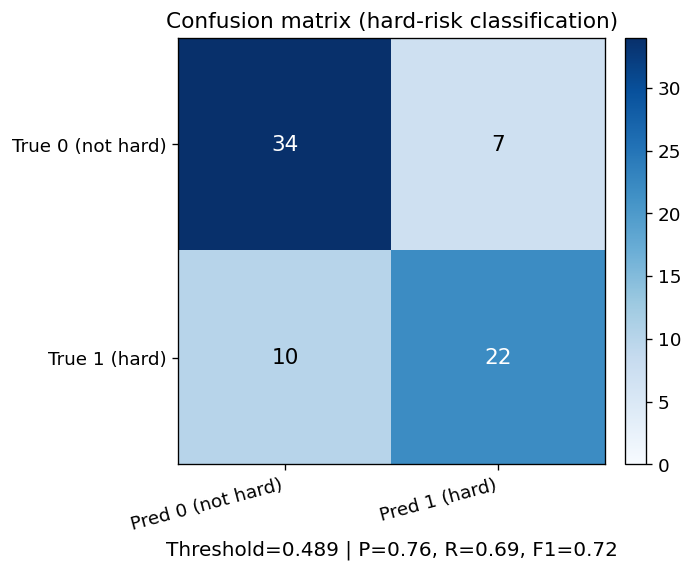

In [10]:
# Cell — Confusion matrix with readable colors + annotations
import numpy as np
import matplotlib.pyplot as plt

y_col = "y_classification_true_01"
p_col = "p_hard"

y_true = final_df[y_col].to_numpy(dtype=int)
p = final_df[p_col].to_numpy(dtype=float)

thr = 0.4892127911249797
y_pred = (p >= thr).astype(int)

tp = int(np.sum((y_pred == 1) & (y_true == 1)))
fp = int(np.sum((y_pred == 1) & (y_true == 0)))
tn = int(np.sum((y_pred == 0) & (y_true == 0)))
fn = int(np.sum((y_pred == 0) & (y_true == 1)))

precision = 0.0 if (tp + fp) == 0 else tp / (tp + fp)
recall = 0.0 if (tp + fn) == 0 else tp / (tp + fn)
f1 = 0.0 if (precision + recall) == 0 else 2 * precision * recall / (precision + recall)

cm = np.array([[tn, fp],
               [fn, tp]])

plt.figure(figsize=(5.8, 4.9))
im = plt.imshow(cm, cmap="Blues", vmin=0, vmax=cm.max())
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.title("Confusion matrix (hard-risk classification)")
plt.xticks([0, 1], ["Pred 0 (not hard)", "Pred 1 (hard)"], rotation=15, ha="right")
plt.yticks([0, 1], ["True 0 (not hard)", "True 1 (hard)"])

# annotate with contrast-aware text color
thresh_for_text = cm.max() / 2
for (i, j), v in np.ndenumerate(cm):
    color = "white" if v > thresh_for_text else "black"
    plt.text(j, i, f"{v}", ha="center", va="center", color=color, fontsize=13)

plt.xlabel(f"Threshold={thr:.3f} | P={precision:.2f}, R={recall:.2f}, F1={f1:.2f}")
plt.tight_layout()
plt.show()

threshold = 0.4892 means if the model’s hardness probability p_hard ≥ 0.4892, it predicts hard (1), otherwise predict not hard (0).

Confusion matrix counts:

TP = 22: truly hard, predicted hard

FP = 7: truly not hard, predicted hard (false alarms)

TN = 34: truly not hard, predicted not hard

FN = 10: truly hard, predicted not hard (missed hard cases)

Precision = 0.759: when the model predicted a case hard to predict, it was right ~76% of the time.

Recall = 0.688: it catched ~69% of all truly hard cases.

in the hrd-risk probabilty distribution plot, the true-hard is shifted higher, but there’s overlap around ~0.3–0.6 which shows exactly where FP and FN come from.

Based on what the focus is (what specificty a lab requires, we can change the threshold (for example they might prefer a model that captures all hard cases, in that case we would lower the threshold, which would result in higher recall, and lower precision. or vice vera, if “false alarms” are expensive, we raise the threshholde)

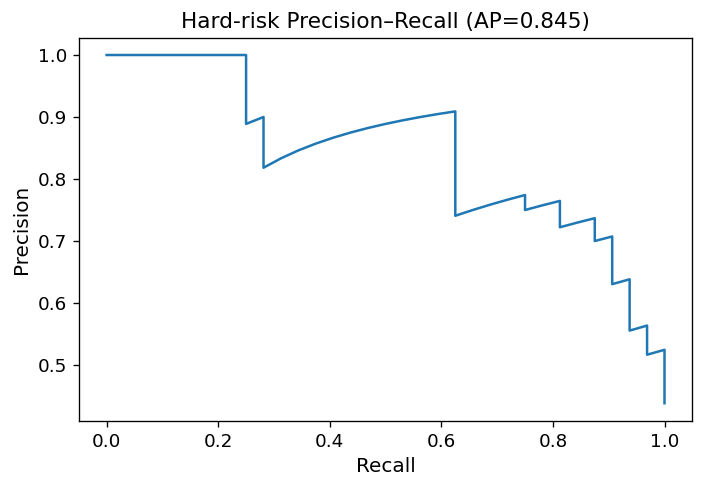

In [15]:
y_true = final_df[col_y_hard].to_numpy(dtype=int)
p = final_df[col_p_hard].to_numpy(dtype=float)

prec, rec, _ = precision_recall_curve(y_true, p)
ap = average_precision_score(y_true, p) if y_true.sum() > 0 else float("nan")

plt.figure(figsize=(6.0, 4.2))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Hard-risk Precision–Recall (AP={ap:.3f})")
plt.tight_layout()
savefig("final_pr_curve")
plt.show()

the classifier shows strong ranking performance (AP=0.845), indicating it effectively prioritizes truly hard targets among the highest predicted risks. the curve staying relatively high means when the model ranks targets as higher risk, many truly are hard. the drop toward high recall confirms in order for us to catch almost all hard cases, we must accept more false positives.

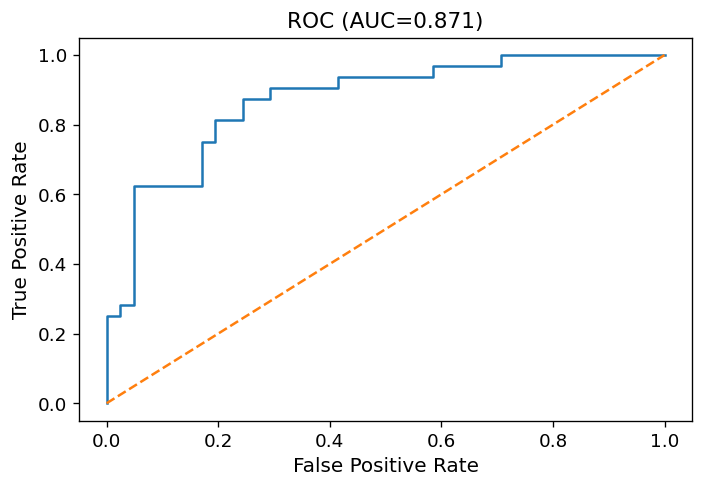

In [16]:
if np.unique(y_true).size < 2:
    print("ROC-AUC undefined (only one class present in y_true).")
else:
    fpr, tpr, _ = roc_curve(y_true, p)
    auc = roc_auc_score(y_true, p)

    plt.figure(figsize=(6.0, 4.2))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC (AUC={auc:.3f})")
    plt.tight_layout()
    savefig("final_roc_curve")
    plt.show()

Discrimination is high (ROC-AUC=0.871), showing a good separation of hard vs non-hard across decision thresholds.\

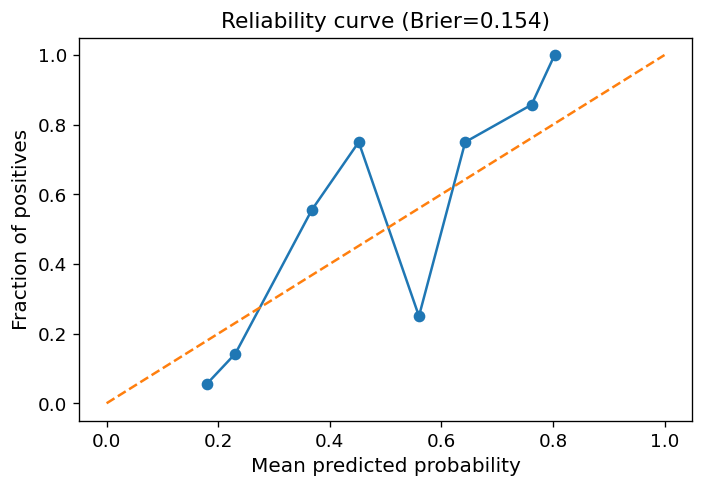

In [17]:
if np.unique(y_true).size < 2:
    print("Reliability curve not meaningful (only one class present).")
else:
    frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy="uniform")
    brier = brier_score_loss(y_true, p)

    plt.figure(figsize=(6.0, 4.2))
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Reliability curve (Brier={brier:.3f})")
    plt.tight_layout()
    savefig("final_reliability_curve")
    plt.show()

the lower the brier score, the better (0 is perfect), and our model shows brier = 0.154. the reliability curve is built by taking all predictions p_hard, and spliting them into bins. for each bin x-axis is the average predicted probability in that bin and y-axis is the fraction of true positives in that bin. if the model is perfectly calibrated, points lie on the diagonal y = x.

the curve shows a zig-zaggy curve which usually means few samples per bin (small test set), so calibration estimates are noisy. places in the plot where the blue curve is above the diagonal is where the model is underconfident (true hard rate > predicted probability), and places where it is below, it’s overconfident.

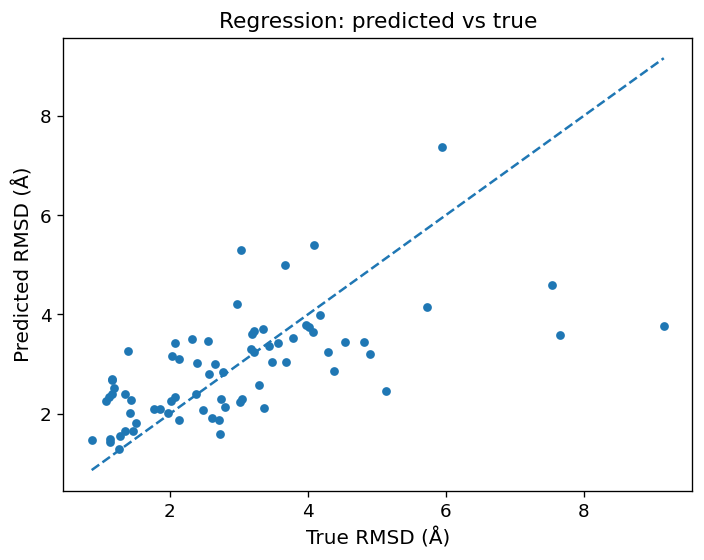

In [18]:
y = final_df[col_y_reg].to_numpy(dtype=float)
yhat = final_df[col_y_hat].to_numpy(dtype=float)

plt.figure(figsize=(6.0, 4.8))
plt.scatter(y, yhat, s=18)
lo = float(np.nanmin([y.min(), yhat.min()]))
hi = float(np.nanmax([y.max(), yhat.max()]))
plt.plot([lo, hi], [lo, hi], linestyle="--")
plt.xlabel("True RMSD (Å)")
plt.ylabel("Predicted RMSD (Å)")
plt.title("Regression: predicted vs true")
plt.tight_layout()
savefig("final_reg_scatter")
plt.show()

Regression predictions correlate with ground truth as most points follow the diagonal trend, showing that the regressor do capture signal. However extreme RMSD outliers are systematically underpredicted (true RMSD ~8–9 Å predicted ~3–4 Å), suggesting systematic underestimation of extreme outliers and remaining unexplained failure modes in high-error targets.

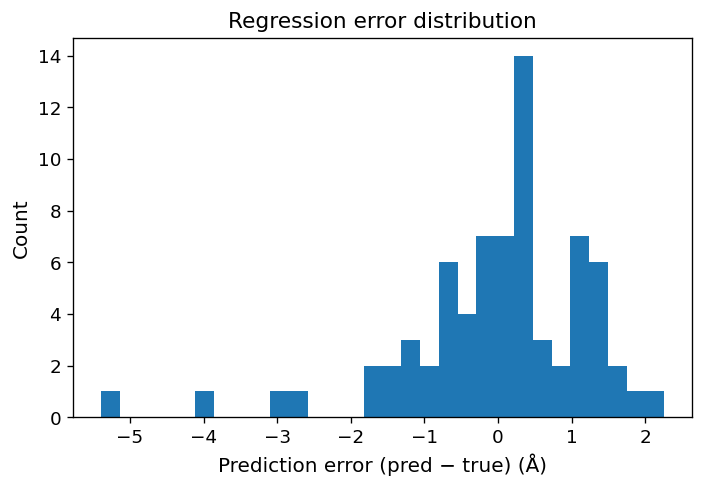

In [19]:
err = yhat - y

plt.figure(figsize=(6.0, 4.2))
plt.hist(err, bins=30)
plt.xlabel("Prediction error (pred − true) (Å)")
plt.ylabel("Count")
plt.title("Regression error distribution")
plt.tight_layout()
savefig("final_reg_error_hist")
plt.show()

most errors are concentrated near zero (typical predictions are close), with a pronounced negative tail driven by underestimation of the highest-RMSD targets (down to about -5 Å), which are the underpredicted high-RMSD cases we see in the scatter plot above.

Empirical coverage: 0.918
Mean PI width:     3.706 Å
Median PI width:   3.706 Å


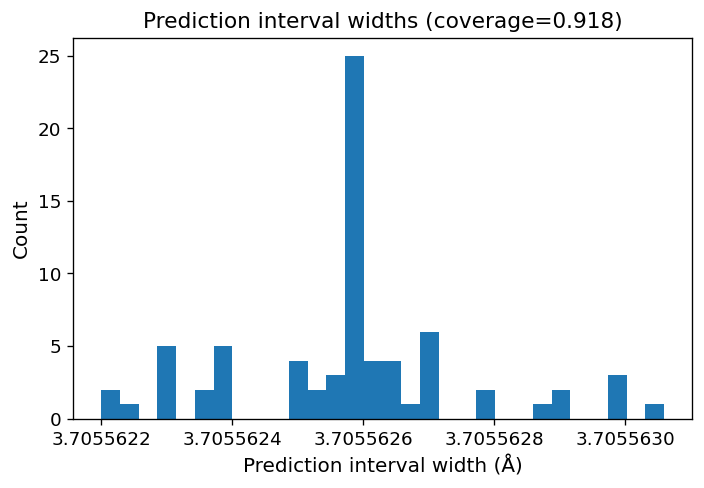

In [20]:
pi_lo = final_df[col_pi_lo].to_numpy(dtype=float)
pi_hi = final_df[col_pi_hi].to_numpy(dtype=float)

covered = (y >= pi_lo) & (y <= pi_hi)
coverage = float(np.mean(covered))
width = pi_hi - pi_lo

print(f"Empirical coverage: {coverage:.3f}")
print(f"Mean PI width:     {float(np.mean(width)):.3f} Å")
print(f"Median PI width:   {float(np.median(width)):.3f} Å")

plt.figure(figsize=(6.0, 4.2))
plt.hist(width, bins=30)

ax = plt.gca()
ax.ticklabel_format(style="plain", axis="x", useOffset=False)

plt.xlabel("Prediction interval width (Å)")
plt.ylabel("Count")
plt.title(f"Prediction interval widths (coverage={coverage:.3f})")
plt.tight_layout()
savefig("final_pi_width_hist")
plt.show()

in conformal prediction, α is the allowed error rate for the prediction intervals. if alpha = 0.10, we’re targeting 90% coverage target 

coverage = 1 − 𝛼 = 0.90

so 0.918 vs nominal 0.90 at α=0.10 means our 90% prediction intervals actually contained the true RMSD 91.8% of the time on the held-out test set. meaning the intervals cover a bit more than required, and our uncertainty bounds provides reliable uncertainty bounds on held-out data.

In [21]:
ds, train_idx, test_idx, res = rebuild_ds_for_run(FINAL_DIR)

alpha = float(safe_get(res, "test.metrics.reg_conformal_alpha", np.nan))
target_cov = (1 - alpha) if np.isfinite(alpha) else np.nan

y_true = final_df[col_y_hard].to_numpy(dtype=int)
p = final_df[col_p_hard].to_numpy(dtype=float)

ap = average_precision_score(y_true, p) if y_true.sum() > 0 else float("nan")
auc = roc_auc_score(y_true, p) if np.unique(y_true).size == 2 else float("nan")
brier = brier_score_loss(y_true, p) if np.unique(y_true).size == 2 else float("nan")

y = final_df[col_y_reg].to_numpy(dtype=float)
yhat = final_df[col_y_hat].to_numpy(dtype=float)

rmse = float(np.sqrt(mean_squared_error(y, yhat)))
mae = float(mean_absolute_error(y, yhat))

pi_lo = final_df[col_pi_lo].to_numpy(dtype=float)
pi_hi = final_df[col_pi_hi].to_numpy(dtype=float)
coverage = float(np.mean((y >= pi_lo) & (y <= pi_hi)))

print(f"Regression RMSE: {rmse:.3f} Å")
print(f"Regression MAE:  {mae:.3f} Å")
print(f"PI coverage:     {coverage:.3f} (target ~ {target_cov:.2f})")
print(f"Hard-risk AP:    {ap:.3f}")
print(f"Hard-risk AUC:   {auc:.3f}")
print(f"Hard-risk Brier: {brier:.3f}")
print(f"Plots saved to: {THESIS_DIR.resolve()}")

Regression RMSE: 1.272 Å
Regression MAE:  0.899 Å
PI coverage:     0.918 (target ~ 0.90)
Hard-risk AP:    0.845
Hard-risk AUC:   0.871
Hard-risk Brier: 0.154
Plots saved to: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/model/outputs_esm_alpha10/thesis_plots


The regression model provides accurate point predictions (MAE ~0.9 Å) and reliable uncertainty estimates, with conformal prediction intervals achieving slightly conservative coverage on the test set.

#### Regression performance 
RMSE = 1.272 Å, MAE = 0.899 Å 

typical errors are around ~0.9 Å, and larger errors push RMSE to ~1.27 Å. the predicted vs true scatter shows the model tracks the general trend but tends to underpredict very large RMSDs (true ~8–9 Å but predicted ~3–4 Å for some points) which could happen when high-RMSD cases are rarer 

#### Prediction interval quality 
PI coverage = 0.918 with alpha = 0.10 (target 0.90) - again conforming the uncertainty bands are trustworthy on held-out data. 
Mean/median PI width ≈ 3.706 Å shows how intervals are not tiny and they’re giving a realistic “error bar” size for RMSD prediction. 


#### Hard-risk classification performance 
When the model flag something as hard, it is right about 3 out of 4 times. it can catch about 2 out of 3 truly hard cases. and misses (FN=10) are the main cost of this threshold. however lowering threshold would reduce misses.

In [22]:
ds, train_idx, test_idx, res = rebuild_ds_for_run(FINAL_DIR)

X_train = ds.X.iloc[train_idx].reset_index(drop=True)
X_test  = ds.X.iloc[test_idx].reset_index(drop=True)

y_train_reg = ds.y_regression[train_idx]
y_test_reg  = ds.y_regression[test_idx]

y_train_clf = ds.y_classification[train_idx]
y_test_clf  = ds.y_classification[test_idx]

# Refit models same way as script
reg_name, reg_pipe = tds.xgb_regressor(ds.feature_cols)

spw = float((y_train_clf == 0).sum() / max((y_train_clf == 1).sum(), 1))
clf_name, clf_pipe = tds.xgb_classifier(ds.feature_cols, scale_pos_weight=spw)

reg = clone(reg_pipe).fit(X_train, y_train_reg)

# uncalibrated for SHAP (base decision function)
clf_uncal = clone(clf_pipe).fit(X_train, y_train_clf)

# calibrated for probability evaluation
clf_cal = CalibratedClassifierCV(
    clone(clf_pipe),
    method=tds.CALIBRATION_METHOD,
    cv=tds.CALIBRATION_INNER_CV,
).fit(X_train, y_train_clf)

print("Fitted:", reg_name, "|", clf_name, "| calibrated:", tds.CALIBRATION_METHOD)

Fitted: XGBReg | xgb_classifier | calibrated: sigmoid


XGBReg = gradient-boosted decision tree regressor

xgb_classifier = gradient-boosted decision tree classifier

* they handle nonlinear feature interactions
* they work well on tabular engineered + embedding features
* they don’t need heavy feature scaling
* they’re robust with missing values (plus your imputer)

sigmoid calibration (“Platt scaling”) takes raw classifier scores and fits a sigmoid mapping so that: 0.7 actually corresponds to “~70% of these are hard” (in expectation)

So: ranking + calibrated decision-making.

In [23]:
def get_pipeline_parts(pipe):
    pre = pipe.named_steps.get("pre")
    model = pipe.named_steps.get("reg") or pipe.named_steps.get("clf")
    if pre is None or model is None:
        raise ValueError("Expected Pipeline with steps: ('pre', ...) and ('reg' or 'clf', ...)")
    return pre, model

# Regression pieces
pre_reg, model_reg = get_pipeline_parts(reg)

Xtr_reg = pre_reg.transform(X_train)
Xte_reg = pre_reg.transform(X_test)

feature_names = list(pre_reg.get_feature_names_out())
print("Transformed shapes:", Xtr_reg.shape, Xte_reg.shape)
print("n feature names:", len(feature_names))

Transformed shapes: (410, 352) (73, 352)
n feature names: 352


we had 410 training examples and 73 test examples.

Each example has 352 features after preprocessing. in the final model, that 352 is basically: engineered h3_* features + a block of ESM embedding dimensions (many columns named esm_###)

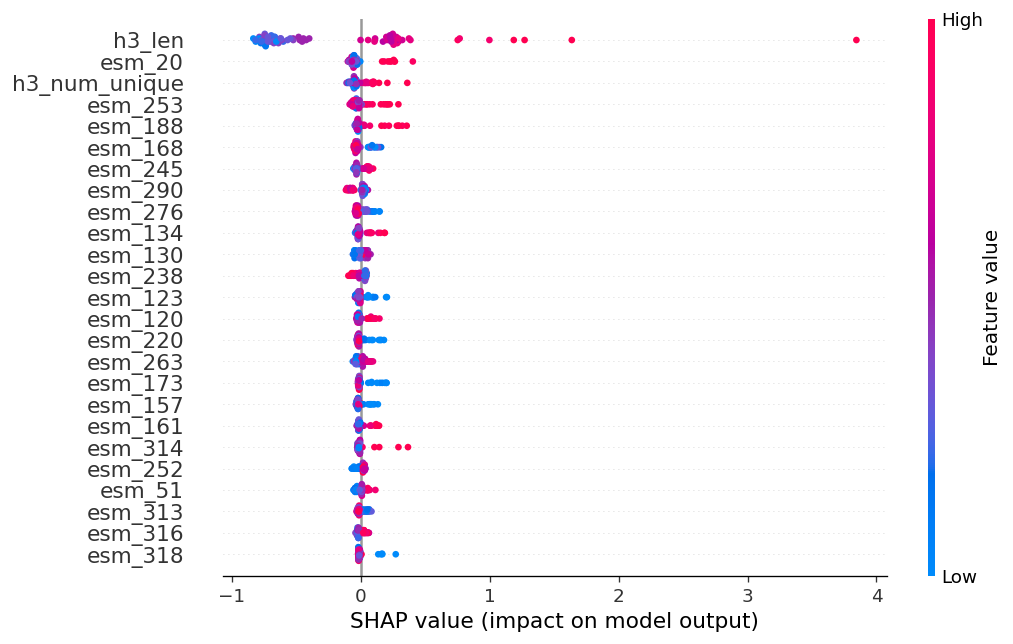

In [24]:
# background sample for SHAP (keeps runtime reasonable)
rng = np.random.default_rng(42)
bg_idx = rng.choice(Xtr_reg.shape[0], size=min(300, Xtr_reg.shape[0]), replace=False)
X_bg = Xtr_reg[bg_idx]

expl_reg = shap.TreeExplainer(model_reg)
shap_values_reg = expl_reg.shap_values(Xte_reg)

# Beeswarm (global importance)
shap.summary_plot(
    shap_values_reg,
    features=Xte_reg,
    feature_names=feature_names,
    show=False,
    max_display=25,
)
plt.gcf().set_size_inches(9, 5.5)
plt.tight_layout()
plt.show()

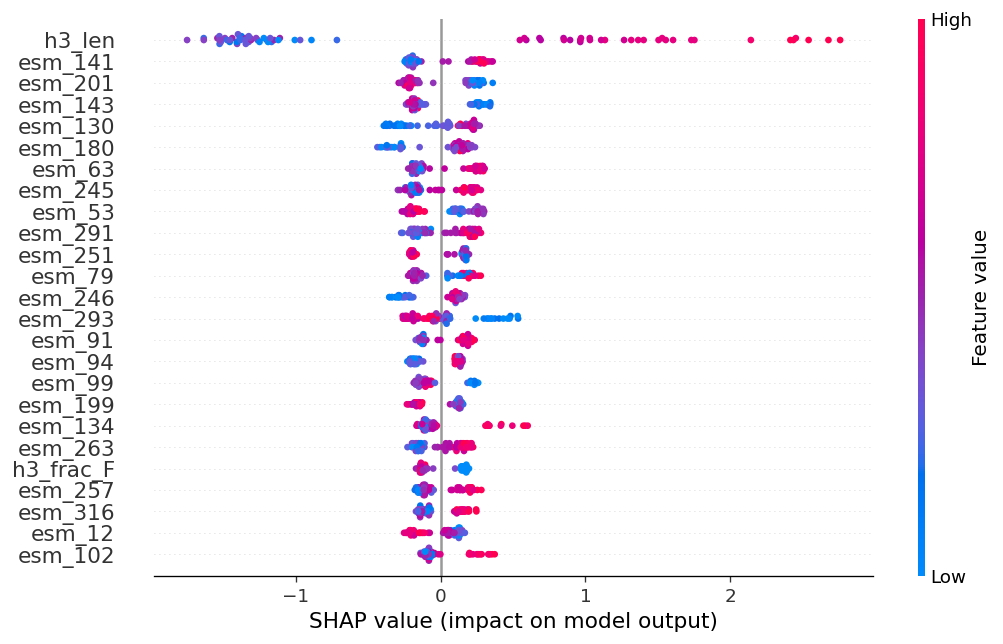

In [25]:
# Pull classifier parts
pre_clf, model_clf = get_pipeline_parts(clf_uncal)

Xtr_clf = pre_clf.transform(X_train)
Xte_clf = pre_clf.transform(X_test)

feature_names_clf = list(pre_clf.get_feature_names_out())

# TreeExplainer supports many tree models + XGBoost
expl_clf = shap.TreeExplainer(model_clf)

# For binary classification, shap returns list/array; we select class 1 if needed.
sv = expl_clf.shap_values(Xte_clf)

# Normalize into "class 1" SHAP values
if isinstance(sv, list) and len(sv) == 2:
    shap_values_clf = sv[1]
else:
    shap_values_clf = sv

shap.summary_plot(
    shap_values_clf,
    features=Xte_clf,
    feature_names=feature_names_clf,
    show=False,
    max_display=25,
)
plt.gcf().set_size_inches(9, 5.5)
plt.tight_layout()
plt.show()

,group,mean_abs_shap
0,ESM embeddings,2.549269
1,length/composition,0.600159
2,other engineered,0.134490
3,physchem,0.015353


,group,mean_abs_shap
0,ESM embeddings,13.794888
1,length/composition,1.428781
2,other engineered,0.276836
3,physchem,0.047259


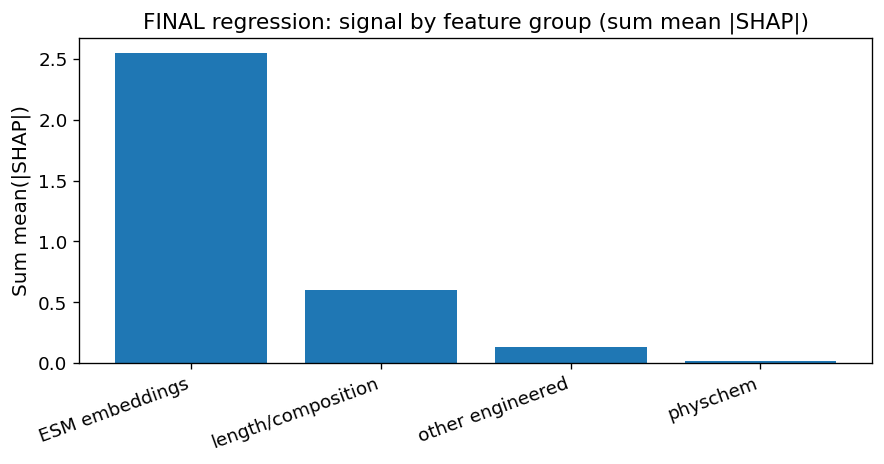

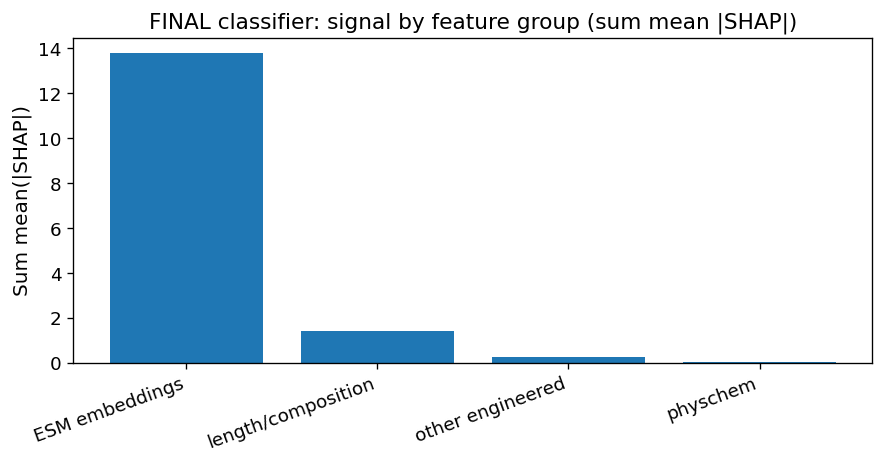

In [26]:
def group_name(feat: str) -> str:
    f = feat.lower()
    if f.startswith("esm_"):
        return "ESM embeddings"
    if "kmer" in f or "3mer" in f:
        return "k-mer rarity"
    if "charge" in f or "hydro" in f or "kyte" in f or "kd" in f or "aromatic" in f:
        return "physchem"
    if "len" in f or "length" in f or "entropy" in f or "composition" in f or "fraction" in f or "freq" in f:
        return "length/composition"
    return "other engineered"

def grouped_abs_shap(shap_vals: np.ndarray, feature_names: List[str]) -> pd.DataFrame:
    abs_mean = np.mean(np.abs(shap_vals), axis=0)
    df = pd.DataFrame({"feature": feature_names, "mean_abs_shap": abs_mean})
    df["group"] = df["feature"].map(group_name)
    g = df.groupby("group", as_index=False)["mean_abs_shap"].sum().sort_values("mean_abs_shap", ascending=False)
    return g, df.sort_values("mean_abs_shap", ascending=False)

g_reg, top_reg = grouped_abs_shap(np.array(shap_values_reg), feature_names)
g_clf, top_clf = grouped_abs_shap(np.array(shap_values_clf), feature_names_clf)

display(g_reg)
display(g_clf)

plt.figure(figsize=(7.5, 4.0))
plt.bar(g_reg["group"], g_reg["mean_abs_shap"])
plt.title("FINAL regression: signal by feature group (sum mean |SHAP|)")
plt.ylabel("Sum mean(|SHAP|)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7.5, 4.0))
plt.bar(g_clf["group"], g_clf["mean_abs_shap"])
plt.title("FINAL classifier: signal by feature group (sum mean |SHAP|)")
plt.ylabel("Sum mean(|SHAP|)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

#### Where is the signal coming from? 

Regression signal (sum mean |SHAP|)

ESM embeddings: 2.55

length/composition: 0.60

other engineered: 0.13

physchem: 0.015

Classifier signal (sum mean |SHAP|)

ESM embeddings: 13.79

length/composition: 1.43

other engineered: 0.28

physchem: 0.047

Most predictive signal comes from sequence representations (ESM embeddings), with a secondary contribution from simple length/composition features. Physicochemical handcrafted features add minimal additional signal in this dataset.

##### Top individual features

Across both models:

h3_len is #1 meaning longer H3 tends to be harder / higher RMSD (very intuitive)

many top contributors are esm_* dimensions so the ESM is capturing sequence patterns related to structure and variability that cdr-h3's features don’t capture.

In [21]:
top_reg.head(25)

,feature,mean_abs_shap,group
0,h3_len,0.590605,length/composition
52,esm_20,0.076606,ESM embeddings
28,h3_num_unique,0.065791,other engineered
285,esm_253,0.055420,ESM embeddings
220,esm_188,0.051812,ESM embeddings
200,esm_168,0.049169,ESM embeddings
277,esm_245,0.040805,ESM embeddings
322,esm_290,0.039544,ESM embeddings
308,esm_276,0.038592,ESM embeddings
166,esm_134,0.032506,ESM embeddings


In [22]:
top_clf.head(25)

,feature,mean_abs_shap,group
0,h3_len,1.366109,length/composition
173,esm_141,0.219950,ESM embeddings
233,esm_201,0.218967,ESM embeddings
175,esm_143,0.208406,ESM embeddings
162,esm_130,0.201940,ESM embeddings
212,esm_180,0.194418,ESM embeddings
95,esm_63,0.192939,ESM embeddings
277,esm_245,0.183767,ESM embeddings
85,esm_53,0.183229,ESM embeddings
323,esm_291,0.175022,ESM embeddings
